# Based on 'A  Neural Probabilistic Language Model' Bengio et al. 2003

In [142]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [143]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [144]:
words = open('Deep_Learning/NLP/makemore/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [145]:
# Build the vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_len = len(stoi)
print(itos)
print('vocab length:', vocab_len)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab length: 27


In [146]:
import random
random.seed(42)
random.shuffle(words)

In [193]:
block_size = 8

def build_dataset(words, device=device):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            # print(''.join(itos[i] for i in context), '-->', itos[idx])
            context = context[1:] + [idx]
    return torch.tensor(X).to(device), torch.tensor(Y).to(device)

split1 = int(0.8 * len(words))
split2 = int(0.9 * len(words))
import random
random.seed(42)
random.shuffle(words)

X_train, Y_train = build_dataset(words[:split1])
X_val, Y_val = build_dataset(words[split1:split2])
X_test, Y_test = build_dataset(words[split2:])


In [216]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

    def to(self, device):
        self.weight = self.weight.to(device)
        if self.bias is not None:
            self.bias = self.bias.to(device)


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            mean = x.mean(dim, keepdim=True)
            var = x.var(dim, keepdim=True)
        else:
            mean = self.running_mean
            var = self.running_var
        x_hat = (x - mean) / (var + self.eps).sqrt()
        self.out = self.gamma * x_hat + self.beta
        if self.training:
            self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    def to(self, device):
        self.gamma = self.gamma.to(device)
        self.beta = self.beta.to(device)
        self.running_mean = self.running_mean.to(device)
        self.running_var = self.running_var.to(device)
    

class Tanh:
    
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    
    def parameters(self):
        return []
    
    def to(self, device):
        pass


class Embedding:

    def __init__(self, num_embeddings, emb_dim):
        self.weight = torch.randn((num_embeddings, emb_dim))# / emb_dim**0.5

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
    def to(self, device):
        self.weight = self.weight.to(device)


class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
    def to(self, device):
        pass

In [217]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)

train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)

In [218]:
# Define the model
n_embd = 10
n_hidden = 68

class Model():
    
    def __init__(self):

        self.layers = [
            Embedding(vocab_len, n_embd), 
            FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, vocab_len)
        ]

        # parameter init
        with torch.no_grad():
            self.layers[-1].weight /= 10.

        self.parameters = [p for l in self.layers for p in l.parameters()]
        for p in self.parameters:
            p.requires_grad = True
    
    def __call__(self, x, eval=False):
        for layer in self.layers:
            x = layer(x)
        return x

    def eval(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False
    
    def train(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True
    
    def to(self, device):
        for layer in self.layers:
            layer.to(device)
        return self

torch.manual_seed(42)
model = Model().to(device)
print(sum(p.nelement() for p in model.parameters))
# Initialise trackers
train_lossi = []
val_lossi = []

22397


In [219]:
def train(lr=0.01, epochs = 10, batch_size=32, eval_every=1, reduce_lr_every=20):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        total_epoch_loss = 0.0
        model.train()
        # update
        if epoch > 0 and epoch % reduce_lr_every == 0:
            lr /= 3.0
        loop = tqdm(train_loader, leave=False)
        for Xmb, Ymb in loop:
            if epoch > 0:
                loop.set_description('Epoch {}/{}'.format(epoch, epochs))
                loop.set_postfix(train_loss=train_lossi[-1], val_loss=val_lossi[-1])

            # forward pass
            logits = model(Xmb)
            loss = F.cross_entropy(logits, Ymb)

            # backward pass
            for p in model.parameters:
                p.grad = None
            loss.backward()
            total_epoch_loss += loss.item()

            for p in model.parameters: 
                p.data += -lr * p.grad

        train_lossi.append(total_epoch_loss / len(train_loader))

        if epoch % eval_every == 0:
            with torch.no_grad():
                model.eval()
                for Xmb, Ymb in val_loader:
                    logits = model(Xmb)
                    loss = F.cross_entropy(logits, Ymb)
                    val_lossi.append(loss.item())
                    break

last train loss: 2.0182162580951566


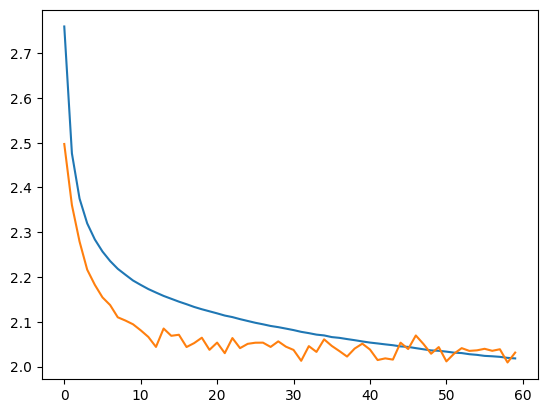

In [222]:
train(epochs = 30, batch_size=128, eval_every=1, reduce_lr_every=50)
plt.plot(train_lossi)
plt.plot(val_lossi)
print(f"last train loss: {train_lossi[-1]}")

In [221]:
# Sampling from the model

model.eval()
for _ in range (20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join(itos[i] for i in out))

yaleen.
jual.
marklleem.
aiyana.
nade.
hadalora.
amzi.
jylah.
marin.
tianna.
adanai.
hanmel.
avonna.
egfis.
kinnon.
rissian.
hamith.
vaichy.
unigon.
larah.
